In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader  
from torch.nn import init
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import time 
import sys
from IPython import display
from matplotlib import pyplot as plt

In [4]:
# generate data
n_train, n_test, true_w, true_b = 100, 100, [1.2, 3.4, 5.6], 5
x = torch.randn(n_train+n_test,1)
poly_x = torch.cat((x, torch.pow(x, 2), torch.pow(x, 3)), 1)
e = torch.tensor(np.random.normal(0, 0.01, (n_train+n_test)), dtype = torch.float) 
y = (true_w[0]*poly_x[:,0]+ true_w[1]*poly_x[:,1] +true_w[2]*poly_x[:,2]+ true_b + e).unsqueeze(1) 

In [5]:
#plot function
def set_figsize(figsize = (3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [13]:
#fit and plot function
def fit_and_plot(num_epoch, batch_size, train_x, train_y, test_x, test_y):
    #model
    network = nn.Linear(train_x.shape[-1], 1)   #注意每一个都是以样本为第一维
    
    #loss
    loss_fn = nn.MSELoss()                      #都是样本数量为第一维度
    
    #optimizer
    optimizer = optim.SGD(network.parameters(), lr=1e-2)
    
    #training dataset
    dataset = TensorDataset(train_x, train_y)
    train_iter = DataLoader(dataset, batch_size, shuffle = True)

    #loss record
    train_loss, test_loss = [], []
    
    #training_loop
    for _ in range(num_epoch):
        for X, y in train_iter:
            y_hat = network(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss_fn(network(train_x),train_y).item())
        test_loss.append(loss_fn(network(test_x),test_y).item())
    print('final epoch: %d, train_loss: %.2f, test_loss: %.2f'%(num_epoch, train_loss[-1], test_loss[-1]))
        
    #plot
    semilogy(range(1, num_epoch+1), train_loss, 'epoch', 'loss',
             range(1, num_epoch+1), test_loss, ['train', 'test'])
    
    #paramsters
    print('weight', network.weight.data, '\nbias', network.bias.data)

In [7]:
num_sample = y.shape[0]
n_test = int(0.25*num_sample)
shuffled_indice = torch.randperm(num_sample)
train_indice = shuffled_indice[:-n_test]
test_indice = shuffled_indice[n_test:] 

train_x = poly_x[train_indice,:]
train_y = y[train_indice,:]
test_x = poly_x[test_indice,:]
test_y = y[test_indice,:]

final epoch: 50, train_loss: 0.00, test_loss: 0.00
weight tensor([[1.2163, 3.3994, 5.5963]]) 
bias tensor([4.9991])


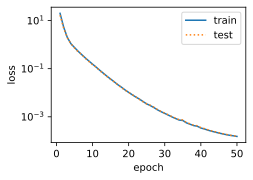

In [19]:
fit_and_plot(num_epoch = 50, batch_size = 10, 
             train_x = train_x, train_y = train_y, 
             test_x = test_x, test_y = test_y)

In [22]:
#data for experiment
num_train, num_test, num_inputs = 20, 100, 200
true_w =  torch.ones(200,1)*0.01
true_b = torch.tensor(0.05)
e = torch.tensor(np.random.normal(0, 0.01, (num_test+num_train, 1)), dtype = torch.float)
x = torch.randn(num_train+num_test, num_inputs, dtype = torch.float)
y = torch.matmul(x, true_w)+true_b+e

In [25]:
#divide dataset into train_data and test_data
shuffled_indice = torch.randperm(num_train+num_test)
train_x = x[shuffled_indice[:20],:] 
train_y = y[shuffled_indice[:20],:] 
test_x = x[shuffled_indice[20:],:]
test_y = y[shuffled_indice[20:],:]

In [32]:
def linreg(x, w, b):
    return torch.matmul(x, w)+b
def loss_mse(y_hat, y):
    return 0.5*(torch.pow((y_hat-y),2).mean())
def l2_penalty(lamda, w):
    return 0.5*lamda*(torch.pow(w,2).sum())
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size 

In [40]:
w = torch.randn(num_inputs, 1, requires_grad = True)
b = torch.zeros(1, requires_grad = True)

In [34]:
def fit_and_plot(n_epoch, batch_size, params, lamda, lr, train_x, train_y, test_x, test_y):
    dataset = TensorDataset(train_x, train_y)
    train_iter = DataLoader(dataset, batch_size,shuffle = True)
    train_loss, test_loss = [], []
    for _ in range(n_epoch):
        for X, y in train_iter:
            loss = loss_mse(linreg(X, *params), y) + l2_penalty(lamda, w)
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            loss.backward()
            sgd(params, lr, batch_size)
        train_loss.append((loss_mse(linreg(train_x, *params), train_y)/len(train_x)).item())
        test_loss.append((loss_mse(linreg(test_x, *params), test_y)/len(test_x)).item())
    print('final epoch: %d, train_loss: %.2f, test_loss: %.2f'%(n_epoch, train_loss[-1], test_loss[-1]))
    #plot
    semilogy(range(1, n_epoch+1), train_loss, 'epoch', 'loss',
             range(1, n_epoch+1), test_loss, ['train', 'test'])
    
    #paramsters
    print('L2 norm of w:', w.norm().item())
    
    

final epoch: 100, train_loss: 0.00, test_loss: 0.04
L2 norm of w: 0.08985631167888641


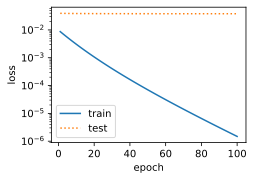

In [44]:
fit_and_plot(n_epoch = 100, batch_size = 10, 
             params = [w,b], lamda = 0, lr = 3e-3, 
             train_x = train_x, train_y = train_y, test_x = test_x, test_y = test_y)

final epoch: 100, train_loss: 0.00, test_loss: 0.03
L2 norm of w: 0.07837127149105072


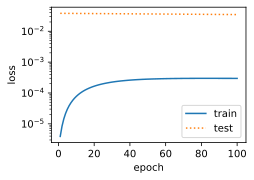

In [45]:
fit_and_plot(n_epoch = 100, batch_size = 10, 
             params = [w,b], lamda = 10, lr = 3e-3, 
             train_x = train_x, train_y = train_y, test_x = test_x, test_y = test_y)

In [50]:
def fit_and_plot_pytorch(n_epoch, batch_size, lr, wd, train_x, train_y, test_x, test_y):
    dataset = TensorDataset(train_x, train_y)
    train_iter = DataLoader(dataset, batch_size,shuffle = True)
    train_loss, test_loss = [], []
    network = nn.Linear(train_x.shape[1], 1)
    optimizer_w = optim.SGD(params = [network.weight], lr = lr, weight_decay = wd)
    optimizer_b = optim.SGD(params = [network.bias], lr = lr)
    for _ in range(n_epoch):
        for X, y in train_iter:
            loss = loss_mse(network(X), y) 
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()    
            loss.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_loss.append(loss_mse(network(train_x), train_y).item())
        test_loss.append(loss_mse(network(test_x), test_y).item())
    print('final epoch: %d, train_loss: %.2f, test_loss: %.2f'%(n_epoch, train_loss[-1], test_loss[-1]))
    #plot
    semilogy(range(1, n_epoch+1), train_loss, 'epoch', 'loss',
             range(1, n_epoch+1), test_loss, ['train', 'test'])
    
    #paramsters
    print('L2 norm of w:', network.weight.data.norm().item())
    

final epoch: 100, train_loss: 313828693831189611033347103077171200.00, test_loss: 121174572323011734243436871506984960.00
L2 norm of w: 5.167326263928422e+16


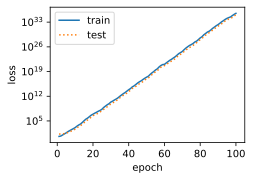

In [51]:
fit_and_plot_pytorch(n_epoch = 100, lr = 0.01, batch_size = 10, wd = 0, train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)